# Explainable AI - Airline Passenger Satisfaction

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sdv.single_table import GaussianCopulaSynthesizer 
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality


# !pip install scikit-learn==1.6.1
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# !pip install lightgbm==4.6.0
import lightgbm as lgb

# !pip install shap==0.47.2
import shap

pd.set_option('display.max_columns', None)




# import warnings
# warnings.filterwarnings("ignore")

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
color_1 = 'mediumpurple'
color_2 = 'olivedrab'

cmap='mako_r'

### Helper Functions

In [4]:
def get_previous_month_start(current_date):
    first_day_current_month = current_date.replace(day=1)
    last_day_previous_month = first_day_current_month - timedelta(days=1)
    first_day_previous_month = last_day_previous_month.replace(day=1)
    return first_day_previous_month

### Load Data

In [5]:
train_df = pd.read_csv('train.csv', low_memory=False)
train_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
train_df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,satisfied
103901,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [6]:
test_df = pd.read_csv('test.csv', low_memory=False)
test_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
test_df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
25972,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,satisfied
25973,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
25974,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied


### Join Data

In [7]:
df = pd.concat([train_df, test_df])
df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
25972,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,satisfied
25973,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
25974,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied


### Feature and Target

In [8]:
# Identify object columns
categorical_features = df.select_dtypes(include='object').columns.tolist()

In [9]:
target = 'satisfaction'
features = [c for c in df.columns.tolist() if c not in [target]]

In [10]:
numerical_features = [f for f in features if f not in categorical_features]
numerical_features

['Age',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

### Generate Synthetic Data

In [ ]:
# Create a metadata object
metadata = SingleTableMetadata()

# Detect the metadata from the original df
metadata.detect_from_dataframe(data=df)

# Fit the data with SDV
print("Fitting SDV Synthesizer to original data (this might take a moment)")

# SDV can usually detect metadata automatically
synthesizer = GaussianCopulaSynthesizer(metadata)

# Fit the synthesizer to your original data
synthesizer.fit(data=df)
print("SDV Synthesizer fitted successfully.")

In [ ]:
# Generate data for 12 months
num_iterations = 12 
initial_month_start = datetime(2025, 7, 1).date()

# Store monthly data
synthetic_data = []

# Instantiate month start date
current_iteration_month_start = initial_month_start

# iterate through the months
for i in range(num_iterations):
    # Determine the month start date for the current iteration
    if i == 0:
        pass
    else:
        current_iteration_month_start = get_previous_month_start(current_iteration_month_start)

    print(f"\t- Generating synthetic data for: {current_iteration_month_start.strftime('%Y-%m-%d')}")

    # Determine the number of rows to generate for this specific month
    # Example: between 10000 and 30000 rows
    rows_to_generate_this_month = np.random.randint(20000, 30000) 

    # Generate the synthetic data for this month using the fitted synthesizer
    temp_df = synthesizer.sample(num_rows=rows_to_generate_this_month)

    # Add the Month start date
    temp_df['Month'] = current_iteration_month_start

    # Append current Month
    synthetic_data.append(temp_df)

# Concatenate all generated data
synthetic_df = pd.concat(synthetic_data).sort_values(by='Month').reset_index(drop=True)
print(f"Total rows in the combined synthetic DataFrame: {len(synthetic_df)}")


# Verify the quality of the synthetic data

print("Evaluating Synthetic Data Quality (this may take a few minutes)")
quality_report = evaluate_quality(
                                    df,
                                    synthetic_df[df.columns.tolist()],
                                    metadata=synthesizer.metadata # Use the metadata learned by the synthesizer
                                )
print(f"\t- Quality Report (score closer to 1.0 is better): {quality_report.get_score()}")

Fitting SDV Synthesizer to original data (this might take a moment)


/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sdv/single_table/base.py:163: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sdv/single_table/base.py:129: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


SDV Synthesizer fitted successfully.
	- Generating synthetic data for: 2025-07-01
	- Generating synthetic data for: 2025-06-01
	- Generating synthetic data for: 2025-05-01
	- Generating synthetic data for: 2025-04-01
	- Generating synthetic data for: 2025-03-01
	- Generating synthetic data for: 2025-02-01
	- Generating synthetic data for: 2025-01-01
	- Generating synthetic data for: 2024-12-01
	- Generating synthetic data for: 2024-11-01
	- Generating synthetic data for: 2024-10-01
	- Generating synthetic data for: 2024-09-01
	- Generating synthetic data for: 2024-08-01
Total rows in the combined synthetic DataFrame: 306197
Evaluating Synthetic Data Quality (this may take a few minutes)
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 23/23 [00:01<00:00, 11.63it/s]|
Column Shapes Score: 96.65%

(2/2) Evaluating Column Pair Trends: |██████████| 253/253 [00:05<00:00, 45.74it/s]|
Column Pair Trends Score: 89.79%

Overall Score (Average): 93.22%

	- Quality Report (score

In [12]:
synthetic_df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Month
0,Male,Loyal Customer,47,Personal Travel,Eco Plus,524,4,5,2,2,2,4,5,2,1,3,3,5,5,5,0,11.0,satisfied,2024-08-01
1,Male,disloyal Customer,17,Business travel,Eco,405,2,5,0,3,4,2,4,2,4,4,5,1,2,4,0,14.0,satisfied,2024-08-01
2,Male,Loyal Customer,29,Personal Travel,Business,314,4,4,5,3,2,2,4,3,5,4,3,3,5,5,24,79.0,neutral or dissatisfied,2024-08-01
3,Male,Loyal Customer,16,Personal Travel,Eco,550,1,3,4,4,4,4,3,4,1,2,3,5,4,1,0,26.0,neutral or dissatisfied,2024-08-01
4,Female,Loyal Customer,44,Business travel,Eco Plus,1480,2,2,2,1,2,5,3,4,1,3,4,5,4,4,3,7.0,neutral or dissatisfied,2024-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306192,Female,Loyal Customer,10,Personal Travel,Eco,280,4,2,5,4,1,4,1,2,4,1,5,4,1,3,21,42.0,neutral or dissatisfied,2025-07-01
306193,Female,Loyal Customer,7,Business travel,Eco,1279,4,2,5,1,5,5,5,4,4,5,4,5,2,5,0,16.0,neutral or dissatisfied,2025-07-01
306194,Male,Loyal Customer,27,Personal Travel,Eco,82,5,5,2,4,5,4,1,5,3,4,4,5,4,5,0,1.0,neutral or dissatisfied,2025-07-01
306195,Male,disloyal Customer,39,Business travel,Business,2585,0,3,0,5,3,4,1,3,4,2,3,4,5,1,7,13.0,satisfied,2025-07-01


In [13]:
synthetic_df['Month'].value_counts()

Month
2024-11-01    29897
2025-05-01    28870
2025-04-01    28426
2025-02-01    27598
2024-10-01    26902
2024-09-01    26285
2025-07-01    26127
2024-12-01    24046
2025-01-01    23138
2025-06-01    22642
2025-03-01    21162
2024-08-01    21104
Name: count, dtype: int64

### Pre-Processing

In [14]:
synthetic_df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             972
satisfaction                           0
Month                                  0
dtype: int64

In [15]:
synthetic_df['Arrival Delay in Minutes'] = synthetic_df['Arrival Delay in Minutes'].fillna(0)

In [16]:
# Binary encoding
synthetic_df['satisfaction'] = np.where(synthetic_df['satisfaction'] == 'satisfied', 1, 0)

In [17]:
# Convert identified columns to 'category'
for col in categorical_features:
    synthetic_df[col] = synthetic_df[col].astype('category')

In [18]:
categorical_features = [c for c in categorical_features if c not in ['Month', target]]
categorical_features

['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [19]:
synthetic_df['satisfaction'].unique().tolist()

[1, 0]

In [20]:
conditions = [
                synthetic_df['Age'] < 20, 
                synthetic_df['Age'] < 25, 
                synthetic_df['Age'] < 38, 
                synthetic_df['Age'] < 62, 
            ]

choices = [
            'Under 20', 
            '20 to 25', 
            '26 to 37', 
            '38 to 62', 
        ]

synthetic_df['Age Cohort'] = np.select(conditions, choices, 'Over 62')
synthetic_df['Age Cohort'] = synthetic_df['Age Cohort'].astype('category')
categorical_features.append('Age Cohort')
features.append('Age Cohort')

In [21]:
categorical_features

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Age Cohort']

### Loop through Predictions

In [22]:
date_list = sorted(synthetic_df['Month'].unique().tolist())
date_list

[datetime.date(2024, 8, 1),
 datetime.date(2024, 9, 1),
 datetime.date(2024, 10, 1),
 datetime.date(2024, 11, 1),
 datetime.date(2024, 12, 1),
 datetime.date(2025, 1, 1),
 datetime.date(2025, 2, 1),
 datetime.date(2025, 3, 1),
 datetime.date(2025, 4, 1),
 datetime.date(2025, 5, 1),
 datetime.date(2025, 6, 1),
 datetime.date(2025, 7, 1)]

In [23]:
# Parameters for the current model
current_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',
    'n_estimators':1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
    'scale_pos_weight': 1.0,
    'n_jobs': -1,
    'verbose': -1,
}


 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2025-07-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1), datetime.date(2024, 11, 1), datetime.date(2024, 12, 1), datetime.date(2025, 1, 1), datetime.date(2025, 2, 1), datetime.date(2025, 3, 1), datetime.date(2025, 4, 1), datetime.date(2025, 5, 1)]
Val:[datetime.date(2025, 6, 1)]
Test:[datetime.date(2025, 7, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	training's auc: 0.721289	training's binary_logloss: 0.607181	valid_1's auc: 0.714426	valid_1's binary_logloss: 0.612782

Best number of estimators: 179


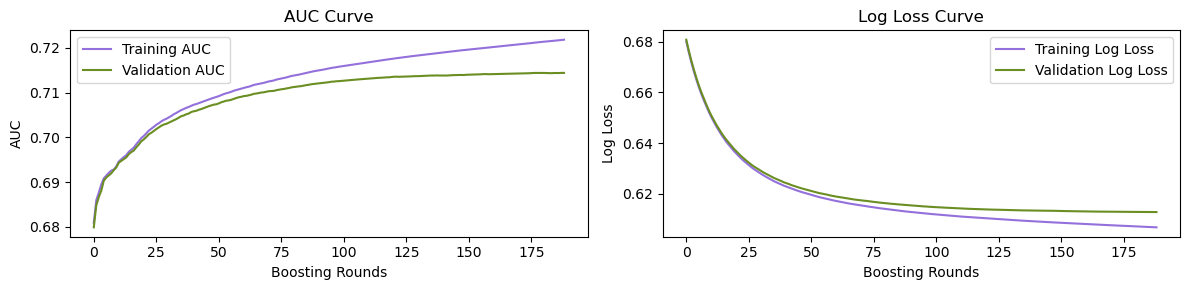

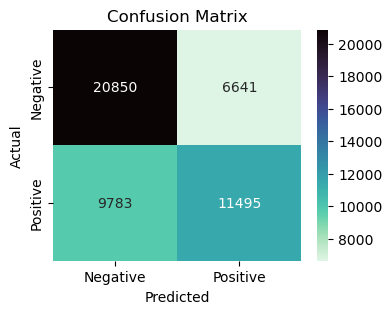

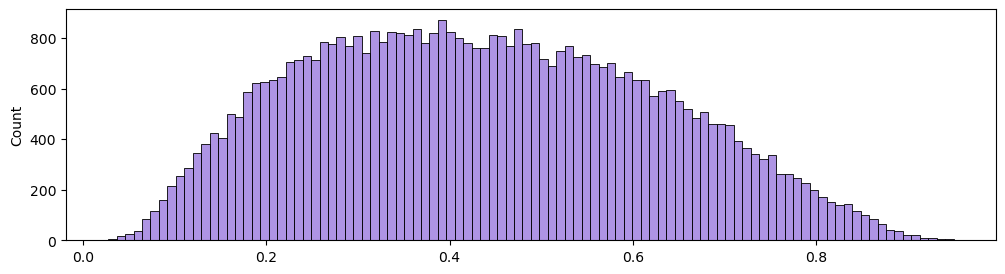

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


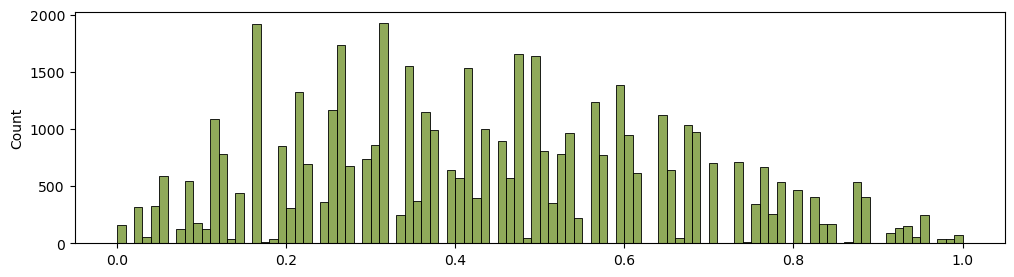

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2025-06-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1), datetime.date(2024, 11, 1), datetime.date(2024, 12, 1), datetime.date(2025, 1, 1), datetime.date(2025, 2, 1), datetime.date(2025, 3, 1), datetime.date(2025, 4, 1)]
Val:[datetime.date(2025, 5, 1)]
Test:[datetime.date(2025, 6, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[197]	training's auc: 0.722962	training's binary_logloss: 0.605928	valid_1's auc: 0.715008	valid_1's binary_logloss: 0.611356

Best number of estimators: 197


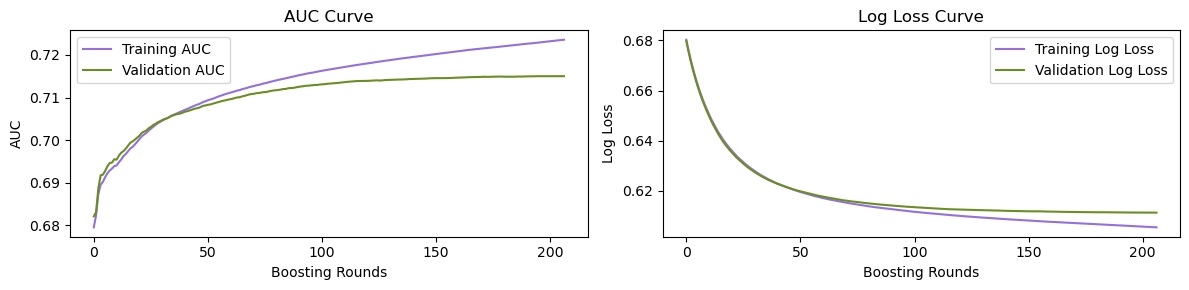

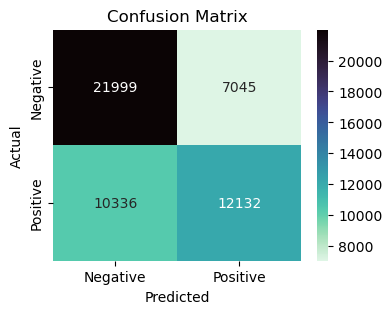

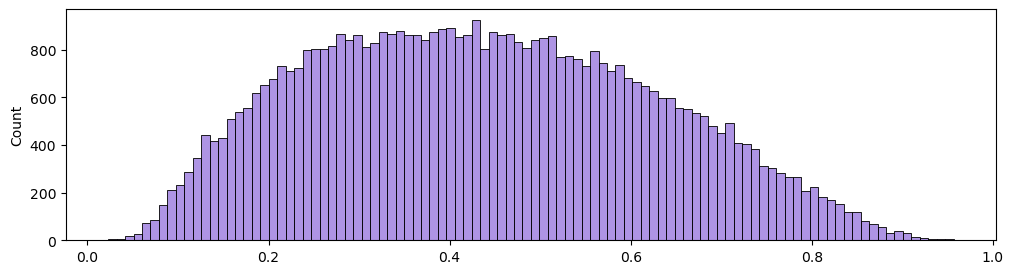

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


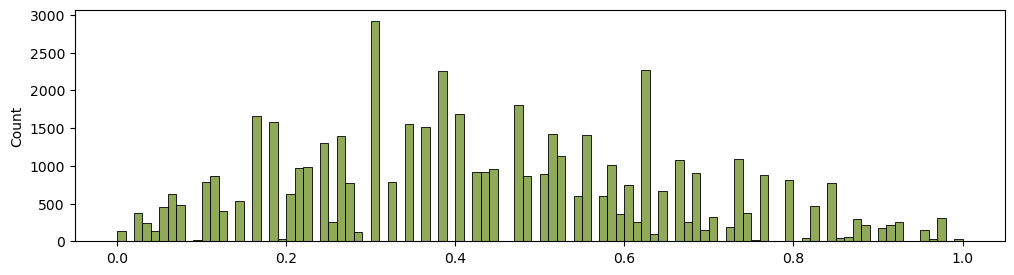

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2025-05-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1), datetime.date(2024, 11, 1), datetime.date(2024, 12, 1), datetime.date(2025, 1, 1), datetime.date(2025, 2, 1), datetime.date(2025, 3, 1)]
Val:[datetime.date(2025, 4, 1)]
Test:[datetime.date(2025, 5, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[183]	training's auc: 0.723775	training's binary_logloss: 0.605271	valid_1's auc: 0.710382	valid_1's binary_logloss: 0.616716

Best number of estimators: 183


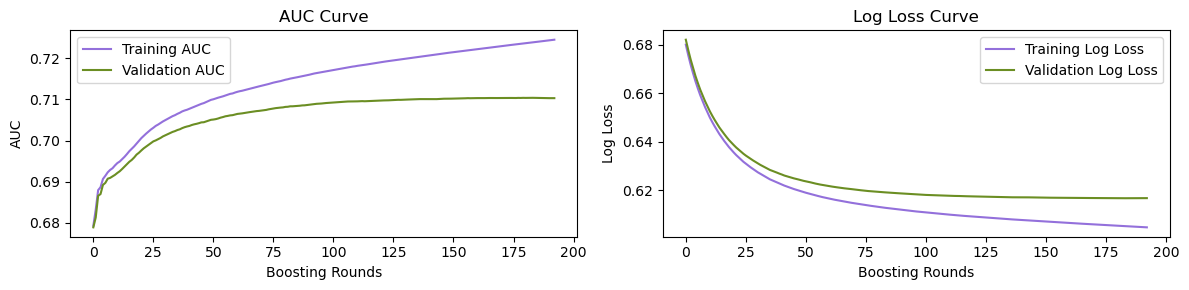

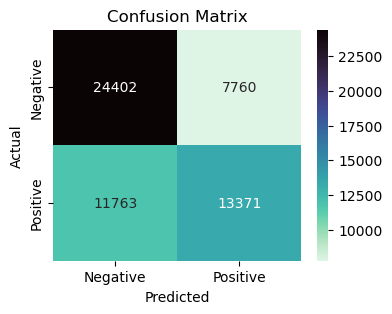

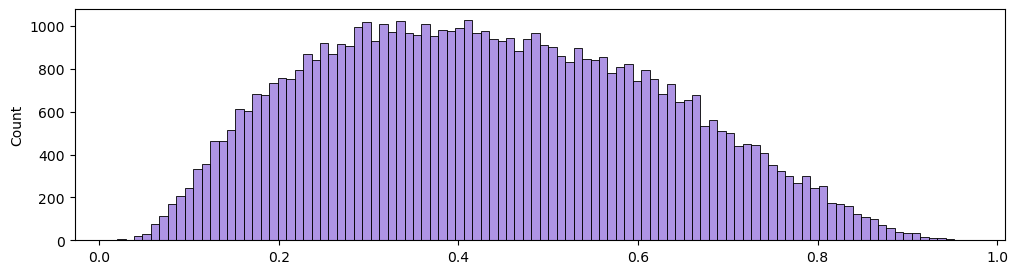

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


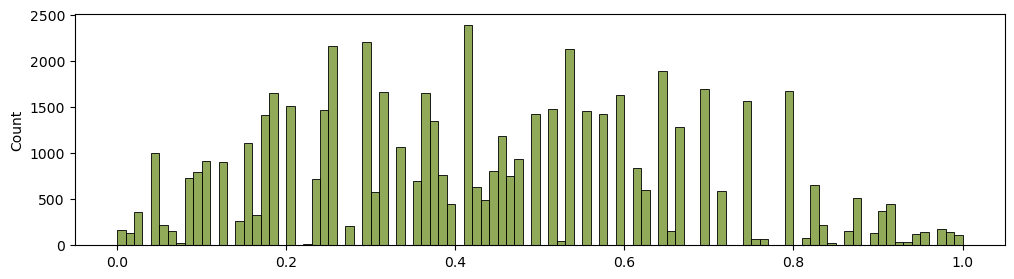

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2025-04-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1), datetime.date(2024, 11, 1), datetime.date(2024, 12, 1), datetime.date(2025, 1, 1), datetime.date(2025, 2, 1)]
Val:[datetime.date(2025, 3, 1)]
Test:[datetime.date(2025, 4, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	training's auc: 0.723725	training's binary_logloss: 0.605198	valid_1's auc: 0.717765	valid_1's binary_logloss: 0.611114

Best number of estimators: 177


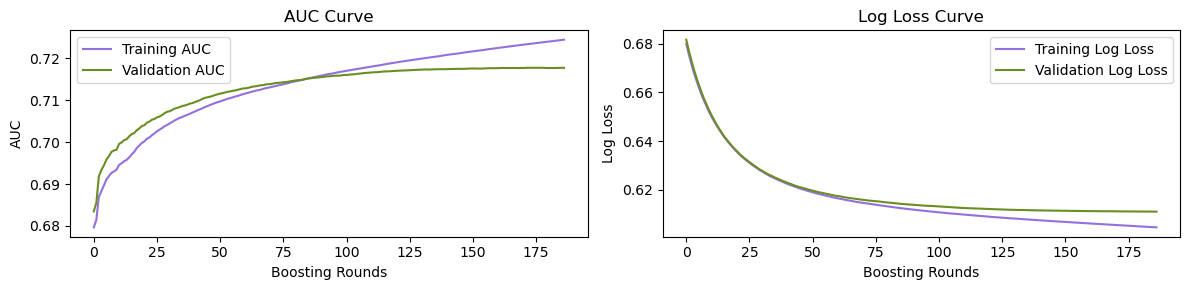

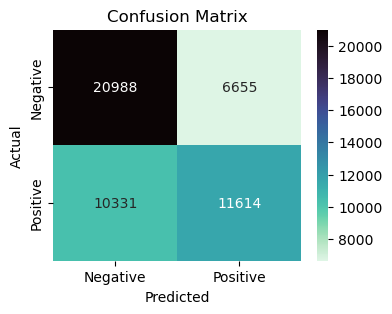

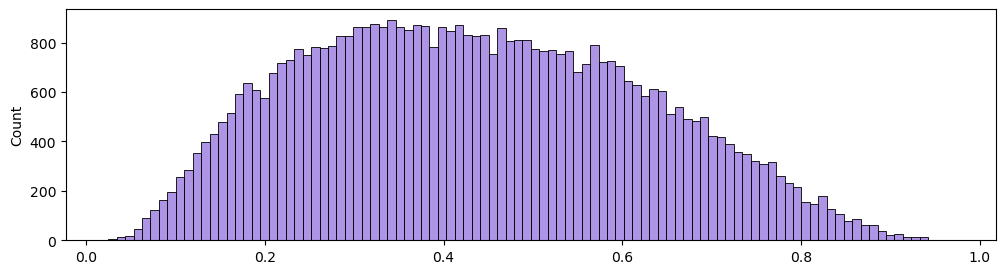

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


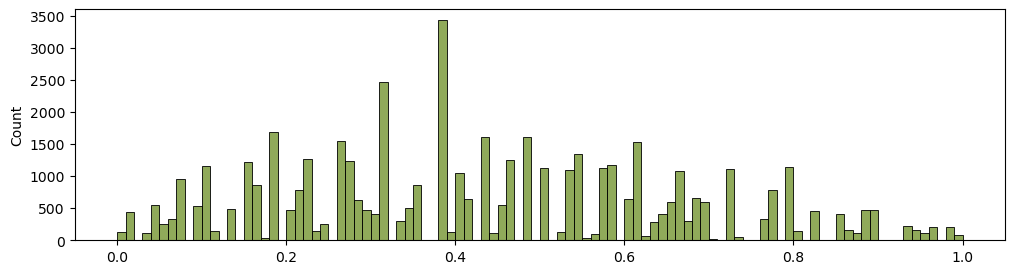

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2025-03-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1), datetime.date(2024, 11, 1), datetime.date(2024, 12, 1), datetime.date(2025, 1, 1)]
Val:[datetime.date(2025, 2, 1)]
Test:[datetime.date(2025, 3, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	training's auc: 0.723749	training's binary_logloss: 0.60555	valid_1's auc: 0.712977	valid_1's binary_logloss: 0.611813

Best number of estimators: 159


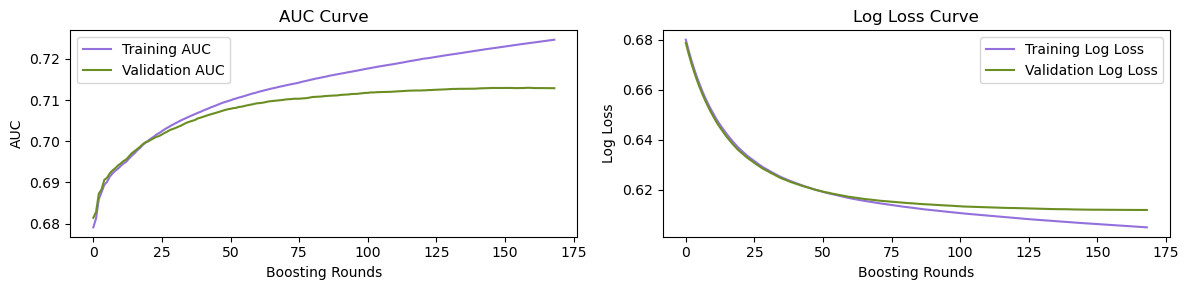

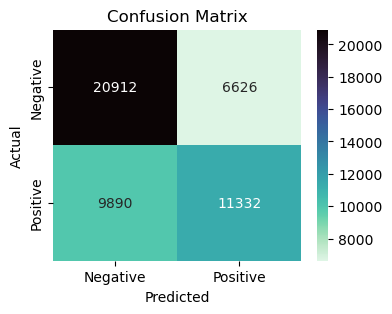

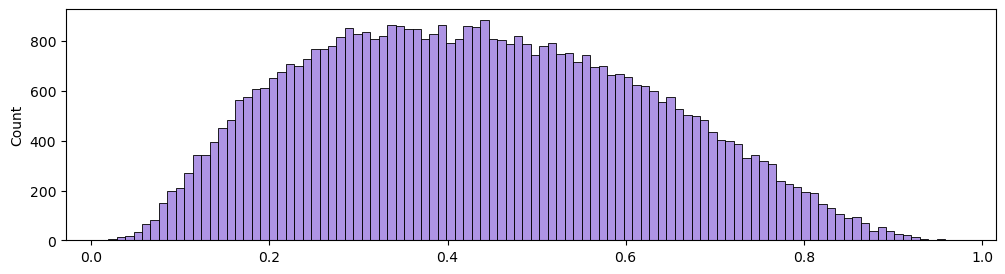

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


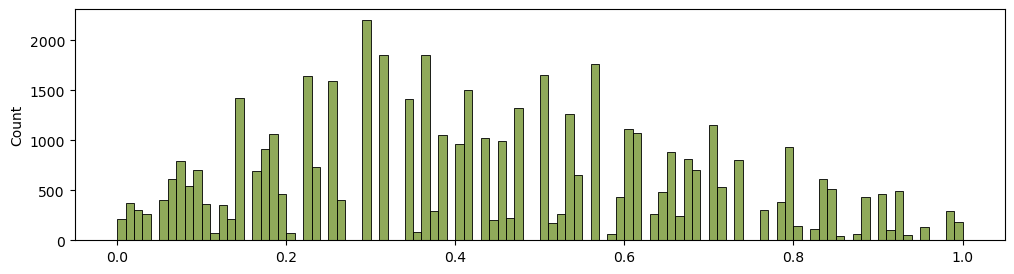

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2025-02-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1), datetime.date(2024, 11, 1), datetime.date(2024, 12, 1)]
Val:[datetime.date(2025, 1, 1)]
Test:[datetime.date(2025, 2, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[173]	training's auc: 0.727726	training's binary_logloss: 0.602874	valid_1's auc: 0.707664	valid_1's binary_logloss: 0.615865

Best number of estimators: 173


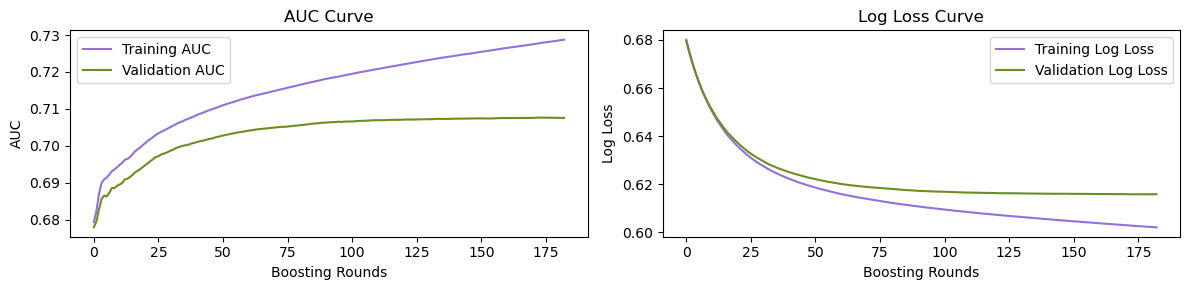

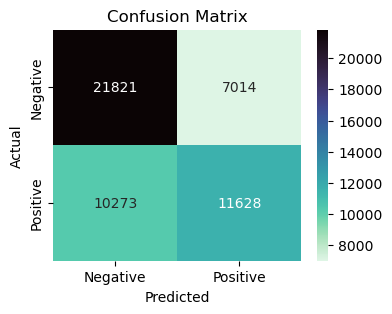

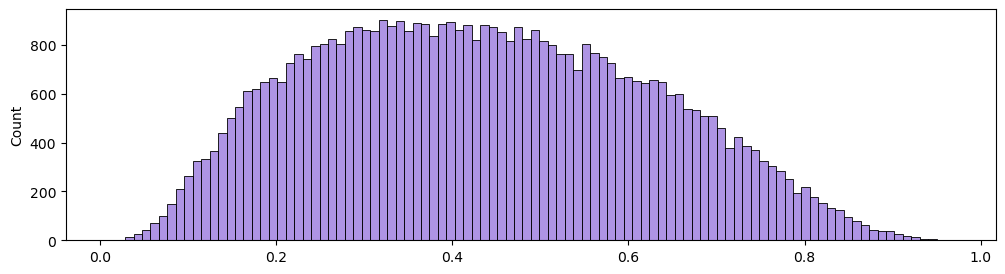

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


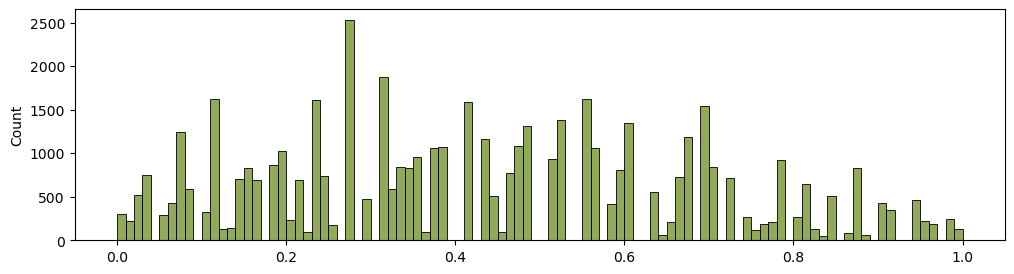

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2025-01-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1), datetime.date(2024, 11, 1)]
Val:[datetime.date(2024, 12, 1)]
Test:[datetime.date(2025, 1, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[144]	training's auc: 0.72734	training's binary_logloss: 0.603459	valid_1's auc: 0.710629	valid_1's binary_logloss: 0.61492

Best number of estimators: 144


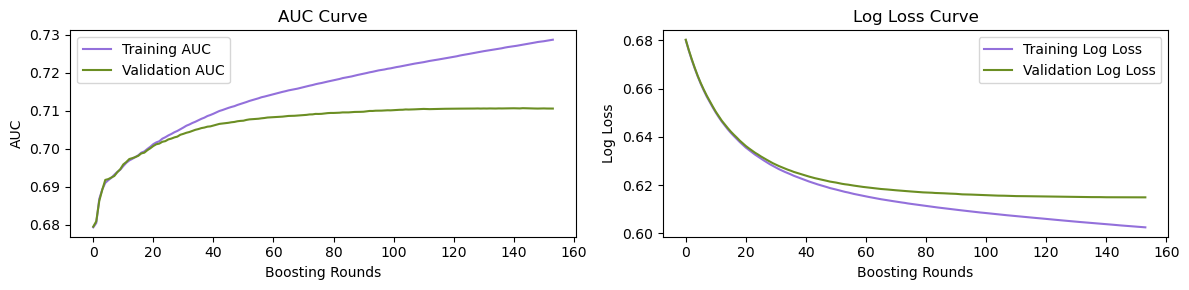

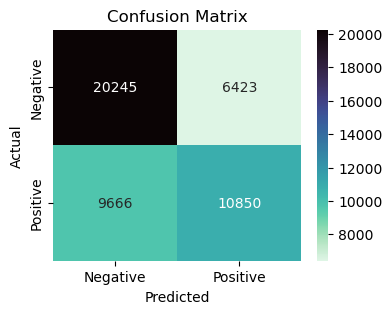

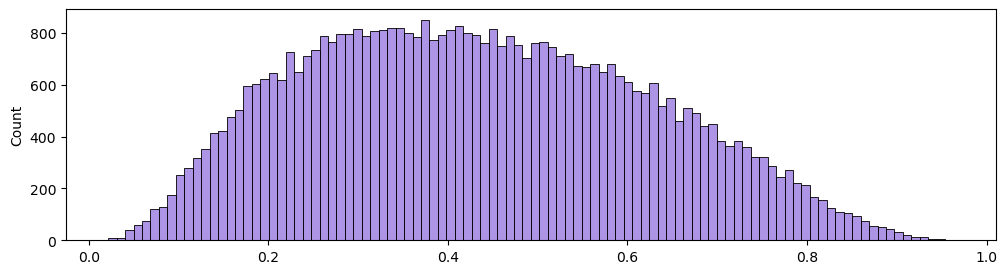

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


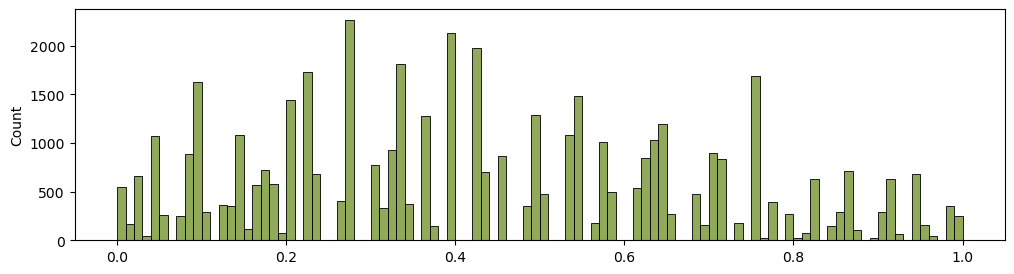

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2024-12-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1), datetime.date(2024, 10, 1)]
Val:[datetime.date(2024, 11, 1)]
Test:[datetime.date(2024, 12, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	training's auc: 0.730654	training's binary_logloss: 0.601356	valid_1's auc: 0.706052	valid_1's binary_logloss: 0.618539

Best number of estimators: 123


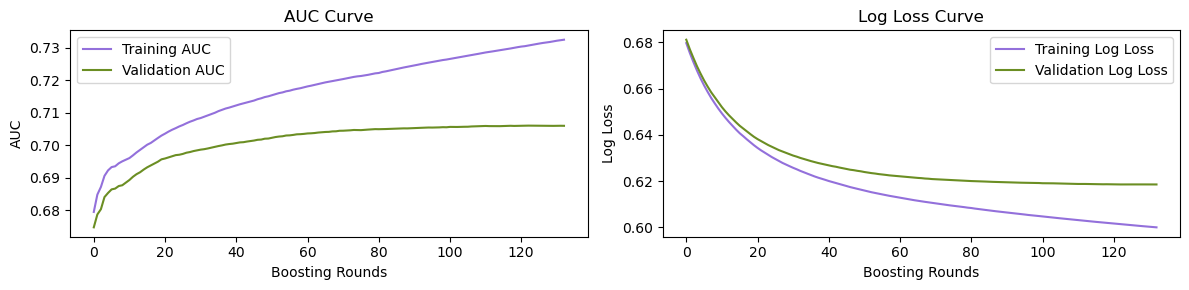

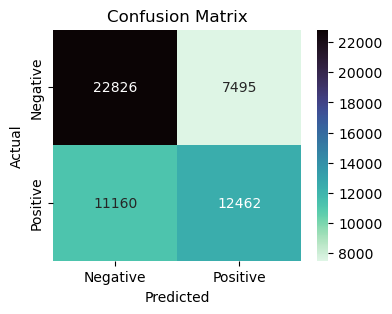

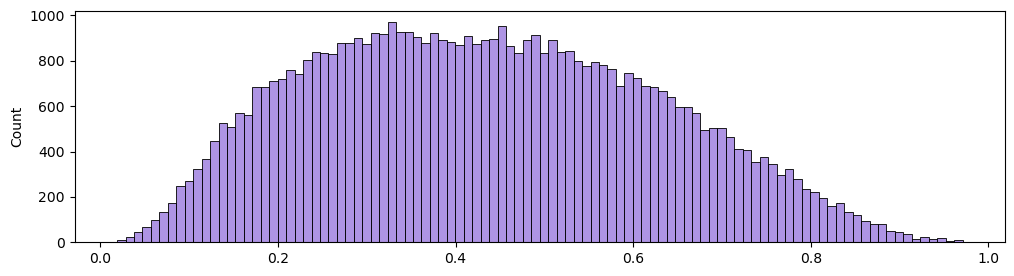

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


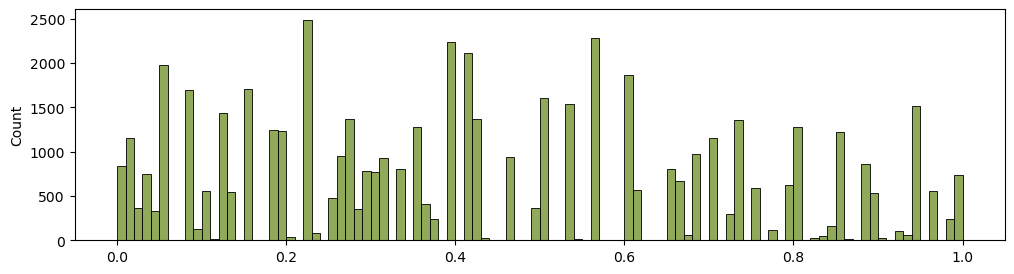

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2024-11-01
Train:[datetime.date(2024, 8, 1), datetime.date(2024, 9, 1)]
Val:[datetime.date(2024, 10, 1)]
Test:[datetime.date(2024, 11, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[135]	training's auc: 0.744358	training's binary_logloss: 0.592498	valid_1's auc: 0.706124	valid_1's binary_logloss: 0.616444

Best number of estimators: 135


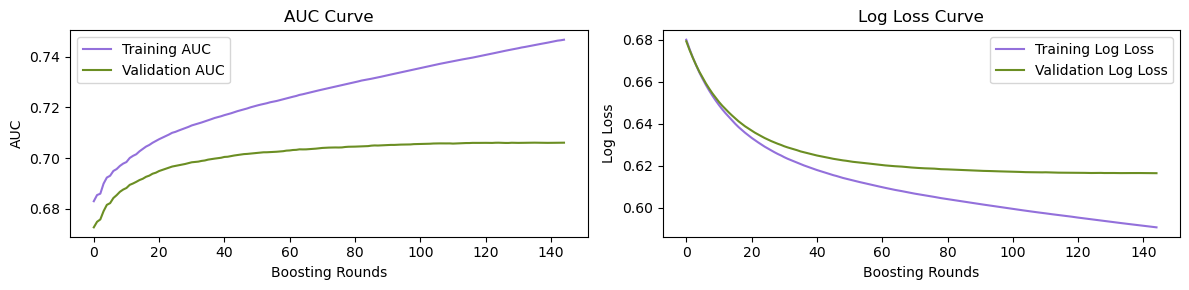

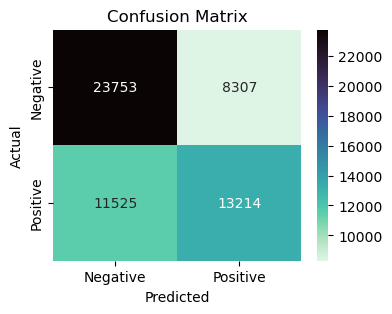

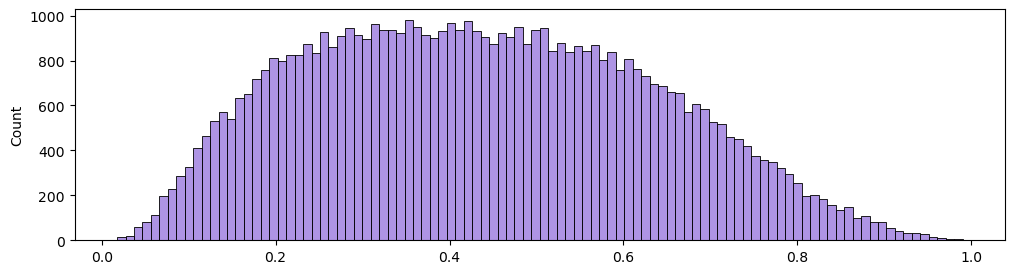

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


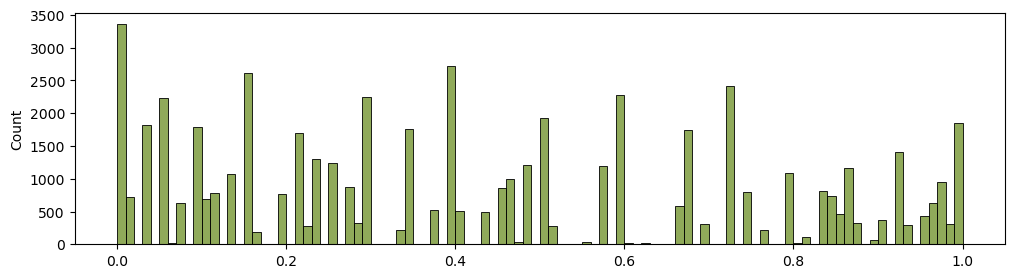

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



 ------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting and Predicting for 2024-10-01
Train:[datetime.date(2024, 8, 1)]
Val:[datetime.date(2024, 9, 1)]
Test:[datetime.date(2024, 10, 1)]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	training's auc: 0.765607	training's binary_logloss: 0.579641	valid_1's auc: 0.698187	valid_1's binary_logloss: 0.622884

Best number of estimators: 92


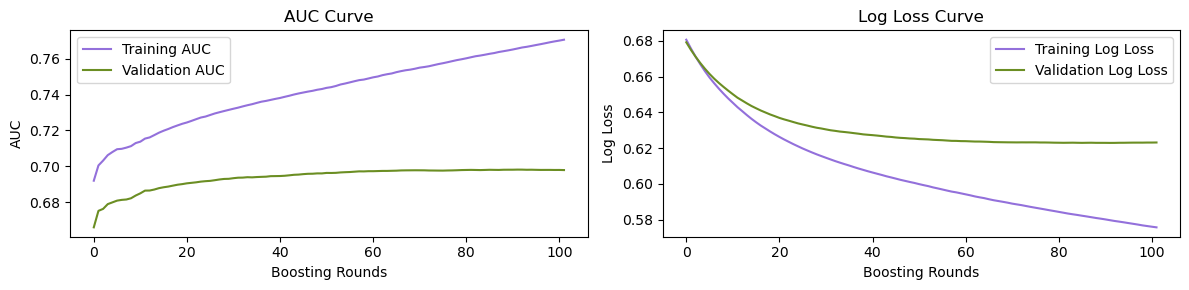

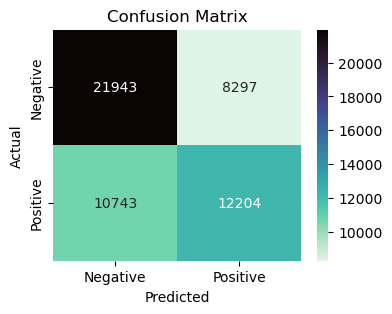

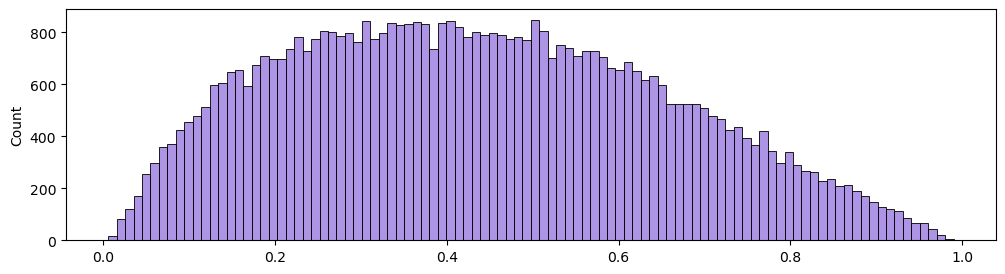

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


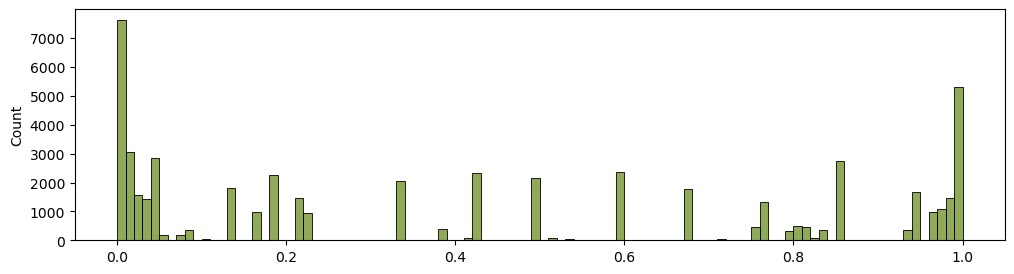

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [24]:

final_df = pd.DataFrame()

for i in range(1, len(date_list)-1):
    print('\n','-'*150)
    print(f'Fitting and Predicting for {date_list[-i]}')

    # ----------------------------------------------------------------------------------
    # Split Data
    # ----------------------------------------------------------------------------------
    test_df = synthetic_df[synthetic_df['Month'] == date_list[-i]]
    val_df = synthetic_df[synthetic_df['Month'] == date_list[:-i][-1]]
    train_df = synthetic_df[synthetic_df['Month'].isin(date_list[:-(i+1)])]

    print(f"Train:{train_df['Month'].unique().tolist()}\nVal:{val_df['Month'].unique().tolist()}\nTest:{test_df['Month'].unique().tolist()}\n")

    X_train = train_df[features]
    y_train = train_df[target]

    X_val = val_df[features]
    y_val = val_df[target]

    X_test = test_df[features]
    y_test = test_df[target]
    # ----------------------------------------------------------------------------------
    # Fit Baseline Model
    # ----------------------------------------------------------------------------------
    # Initialize the LightGBMClassifier
    lgbm_model = lgb.LGBMClassifier(**current_params)

    # Train the LightGBM model with early stopping
    eval_set = [(X_train, y_train), (X_val, y_val)]
    evals_result = {}

    lgbm_model.fit(X_train, y_train,
                    categorical_feature=categorical_features,
                    eval_set=eval_set,
                    eval_metric=['auc', 'binary_logloss'],
                    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=1),
                                lgb.record_evaluation(evals_result)])

    # Make predictions on the test set
    y_pred = lgbm_model.predict(X_test)
    y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]
    # ----------------------------------------------------------------------------------
    # Find Best Estimators from Early Stopping
    # ----------------------------------------------------------------------------------
    # Extract the best number of estimators
    best_n_estimators = lgbm_model.best_iteration_
    print(f"\nBest number of estimators: {best_n_estimators}")
    # ----------------------------------------------------------------------------------
    # Loss Functions
    # ----------------------------------------------------------------------------------
    # Visualize the loss curves
    epochs = len(evals_result['training']['auc']) 
    plt.figure(figsize=(12, 3))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(evals_result['training']['auc'], label='Training AUC', color = color_1)
    plt.plot(evals_result['valid_1']['auc'], label='Validation AUC', color = color_2)
    plt.title('AUC Curve')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('AUC')
    plt.legend()

    # Plot Log Loss
    plt.subplot(1, 2, 2)
    plt.plot(evals_result['training']['binary_logloss'], label='Training Log Loss', color = color_1)
    plt.plot(evals_result['valid_1']['binary_logloss'], label='Validation Log Loss', color = color_2)
    plt.title('Log Loss Curve')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Log Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # ----------------------------------------------------------------------------------
    # Final Baseline Model
    # ----------------------------------------------------------------------------------
    # Parameters for the current model
    best_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',  
        'boosting_type': 'gbdt',
        'n_estimators':best_n_estimators,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'scale_pos_weight': 1.0,
        'n_jobs': -1,
        'verbose': -1,
    }
    # ----------------------------------------------------------------------------------
    # Rejoin Data
    # ----------------------------------------------------------------------------------
    X_test = pd.concat([X_val, X_test])
    y_test = pd.concat([y_val, y_test])
    # ----------------------------------------------------------------------------------
    # Fit Final Model
    # ----------------------------------------------------------------------------------
    # Initialize the LightGBMClassifier
    lgbm_model = lgb.LGBMClassifier(**current_params)

    lgbm_model.fit(X_train, y_train,
                    categorical_feature=categorical_features,
                    )

    # Make predictions on the test set
    y_pred = lgbm_model.predict(X_test)
    y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]
    # ----------------------------------------------------------------------------------
    # Confusion Matrix
    # ----------------------------------------------------------------------------------
    # Visualize the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    # ----------------------------------------------------------------------------------
    # Pred Probas
    # ----------------------------------------------------------------------------------
    calibrated_pred_proba = lgbm_model.predict_proba(X_test)[:,1]
    binned_true_p, binned_predict_p = calibration_curve(y_test, calibrated_pred_proba, n_bins=100)
    # ----------------------------------------------------------------------------------
    # Visualize Calibrated Probas Pre Calibaration
    # ----------------------------------------------------------------------------------
    plt.figure(figsize = (12, 3))
    sns.histplot(calibrated_pred_proba, bins=100, color=color_1)
    plt.show()
    # ----------------------------------------------------------------------------------
    # Calibrate Probas
    # ----------------------------------------------------------------------------------
    calibrated_model = CalibratedClassifierCV(lgbm_model, cv='prefit', method='isotonic')

    calibrated_model.fit(X_train, y_train)

    calibrated_pred_proba = calibrated_model.predict_proba(X_test)[:,1]
    binned_true_p, binned_predict_p = calibration_curve(y_test, calibrated_pred_proba, n_bins=100)
    # ----------------------------------------------------------------------------------
    # Visualize Calibrated Probas Post Calibaration
    # ----------------------------------------------------------------------------------
    plt.figure(figsize = (12, 3))
    sns.histplot(calibrated_pred_proba, bins=100, color=color_2)
    plt.show()
    # ----------------------------------------------------------------------------------
    # SHAP
    # ----------------------------------------------------------------------------------
    # Initialize the SHAP explainer
    explainer = shap.Explainer(lgbm_model)

    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_test)
    # ----------------------------------------------------------------------------------
    # Combine SHAP with Data
    # ----------------------------------------------------------------------------------
    # Grab SHAP values for each prediction
    shap_df = pd.DataFrame(shap_values, columns=[f'{col}_SHAP' for col in X_test.columns], index=X_test.index)

    # It's good practice to keep the original (or scaled) features alongside their SHAP values
    X_test_with_shap = pd.concat([X_test, shap_df], axis=1)

    # Also add the actual satisfaction from y_test for analysis
    X_test_with_shap['satisfaction'] = y_test

    # Add probas
    X_test_with_shap['Pred'] = y_pred
    X_test_with_shap['Pred Proba'] = calibrated_pred_proba

    # Add current Month
    X_test_with_shap['Month'] = date_list[-i]
    
    # Concat
    final_df = pd.concat([final_df, X_test_with_shap]) 

In [38]:
final_df

,GENDER,CUSTOMER_TYPE,AGE,TYPE_OF_TRAVEL,CLASS,FLIGHT_DISTANCE,INFLIGHT_WIFI_SERVICE,DEPARTURE_ARRIVAL_TIME_CONVENIENT,EASE_OF_ONLINE_BOOKING,GATE_LOCATION,FOOD_AND_DRINK,ONLINE_BOARDING,SEAT_COMFORT,INFLIGHT_ENTERTAINMENT,ON_BOARD_SERVICE,LEG_ROOM_SERVICE,BAGGAGE_HANDLING,CHECKIN_SERVICE,INFLIGHT_SERVICE,CLEANLINESS,DEPARTURE_DELAY_IN_MINUTES,ARRIVAL_DELAY_IN_MINUTES,AGE_COHORT,GENDER_SHAP,CUSTOMER_TYPE_SHAP,AGE_SHAP,TYPE_OF_TRAVEL_SHAP,CLASS_SHAP,FLIGHT_DISTANCE_SHAP,INFLIGHT_WIFI_SERVICE_SHAP,DEPARTURE_ARRIVAL_TIME_CONVENIENT_SHAP,EASE_OF_ONLINE_BOOKING_SHAP,GATE_LOCATION_SHAP,FOOD_AND_DRINK_SHAP,ONLINE_BOARDING_SHAP,SEAT_COMFORT_SHAP,INFLIGHT_ENTERTAINMENT_SHAP,ON_BOARD_SERVICE_SHAP,LEG_ROOM_SERVICE_SHAP,BAGGAGE_HANDLING_SHAP,CHECKIN_SERVICE_SHAP,INFLIGHT_SERVICE_SHAP,CLEANLINESS_SHAP,DEPARTURE_DELAY_IN_MINUTES_SHAP,ARRIVAL_DELAY_IN_MINUTES_SHAP,AGE_COHORT_SHAP,SATISFACTION,PRED,PRED_PROBA,MONTH
257428,Female,Loyal Customer,49,Business travel,Business,1447,2,1,4,2,4,4,4,5,5,2,4,3,4,4,5,21.0,38 to 62,-0.005,0.039,0.074,0.183,0.111,0.077,-0.203,0.042,-0.052,-0.007,-0.019,0.139,-0.066,-0.103,0.068,-0.064,0.020,-0.002,0.039,-0.000,0.003,0.009,0.001,0,0,0.491,2025-07-01
257429,Male,Loyal Customer,34,Personal Travel,Eco,1117,3,5,3,3,1,4,5,1,4,1,3,4,3,4,0,2.0,26 to 37,0.006,0.039,-0.074,-0.426,-0.207,0.064,-0.612,-0.027,0.140,-0.016,-0.010,0.151,0.084,-0.014,-0.068,-0.183,0.001,-0.003,-0.171,0.003,0.011,0.117,-0.013,0,0,0.127,2025-07-01
257430,Female,Loyal Customer,31,Business travel,Business,523,3,2,2,4,1,3,4,2,1,4,4,3,5,2,2,109.0,26 to 37,-0.006,0.041,-0.069,0.203,0.137,-0.227,-0.693,-0.009,0.004,-0.015,0.012,-0.154,-0.077,-0.018,-0.043,-0.007,0.009,0.003,0.416,0.015,-0.005,-0.129,-0.006,0,0,0.266,2025-07-01
257431,Female,Loyal Customer,43,Business travel,Eco,491,1,5,4,4,2,4,5,5,3,4,4,4,5,3,1,19.0,38 to 62,-0.006,0.053,0.060,0.182,-0.191,-0.179,0.409,0.004,-0.037,-0.011,-0.002,0.133,0.075,-0.103,0.025,-0.003,0.011,-0.004,0.387,-0.001,0.008,0.014,0.002,1,1,0.659,2025-07-01
257432,Female,Loyal Customer,53,Business travel,Business,760,2,5,4,5,5,3,1,3,5,5,4,2,4,2,0,14.0,38 to 62,-0.013,0.047,0.137,0.187,0.117,-0.118,-0.176,-0.047,-0.065,-0.012,0.014,-0.175,0.022,0.019,0.040,0.027,0.001,0.008,0.049,0.014,0.012,0.026,-0.008,0,0,0.459,2025-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74286,Male,Loyal Customer,49,Business travel,Business,1936,4,5,2,3,2,1,1,1,5,3,2,2,5,1,0,15.0,38 to 62,0.029,0.051,-0.010,0.227,0.112,0.191,-0.075,0.039,0.067,0.012,0.021,0.087,-0.039,-0.045,0.019,0.029,0.014,0.000,0.396,-0.060,0.038,0.109,0.015,1,1,0.984,2024-10-01
74287,Female,Loyal Customer,33,Business travel,Business,354,3,4,2,4,5,5,3,5,5,5,3,4,5,1,3,44.0,26 to 37,0.003,0.068,-0.161,0.224,0.165,-0.432,-0.641,0.001,0.061,-0.025,-0.018,0.040,0.017,-0.072,-0.021,0.113,0.001,0.012,0.524,-0.157,0.056,-0.116,0.036,1,0,0.185,2024-10-01
74288,Male,Loyal Customer,59,Business travel,Business,580,1,5,5,1,2,5,5,3,5,1,1,5,5,3,8,31.0,38 to 62,0.079,0.062,0.409,0.203,0.136,-0.250,0.427,-0.018,0.110,0.010,-0.016,-0.053,0.069,0.029,-0.008,-0.113,0.236,-0.036,0.409,0.028,0.024,0.140,0.015,1,1,1.000,2024-10-01
74289,Female,Loyal Customer,57,Business travel,Eco,403,2,4,4,5,3,4,4,2,3,2,5,2,1,4,0,3.0,38 to 62,0.005,0.052,0.188,0.284,-0.106,-0.401,-0.200,-0.103,-0.051,-0.003,0.010,0.172,-0.041,0.012,0.011,-0.061,-0.003,0.062,-0.471,-0.011,-0.006,0.163,0.002,1,0,0.085,2024-10-01


In [26]:

final_df.columns = [
                    c.upper()
                    .replace(' ', '_')
                    .replace('-', '_')
                    .replace('/', '_')
                    for c in final_df.columns.tolist()
                ]

In [35]:
final_df[[c for c in final_df.columns if c.endswith('SHAP')]] = final_df[[c for c in final_df.columns if c.endswith('SHAP')]].round(3)

In [ ]:
final_df[numerical_features] = final_df[numerical_features].round(3)

In [37]:
final_df['PRED_PROBA'] = final_df['PRED_PROBA'].round(3)

- gcloud auth login
- gcloud auth application-default login

In [39]:
final_df.to_gbq('EXAI.AIRLINE_PASSENGER_SATISFACTION', project_id = 'gemini-sandbox-446215', if_exists='replace')

/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_64748/99782259.py:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  final_df.to_gbq('EXAI.AIRLINE_PASSENGER_SATISFACTION', project_id = 'gemini-sandbox-446215', if_exists='replace')
/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/pandas_gbq/schema/pandas_to_bigquery.py:157: UserWarning: Could not determine the type of columns: SATISFACTION
  warnings.warn(msg)
100%|██████████| 1/1 [00:00<00:00, 2968.37it/s]


['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Age Cohort']